# 第五章 PDF文件和图像处理

- [一、引言 ](#一、引言 )
- [二、文件和图像分析技术](#二、文件和图像分析技术)
  - [2.1文档布局检测](#2.1文档布局检测)
  - [2.2视觉Transformers](#2.2视觉Transformers)
  - [2.3优劣分析](#2.3优劣分析)
- [三、案例演示](#三、案例演示)

##### 

## 一、引言


像PDF和图像这一类文件，需要进行预处理才能和大模型交互。本章会涉及一些预处理的方法，包括“文档布局检测(Document Layout Detection)”和“视觉Transformers(Vision Transformers)",并学习如何使用这些工具完成预处理。对于非结构化的文件，如PDF和图像，我们需要使用它们的视觉信息来完成解析,从中提取格式化的信息和文本。

## 二、文件和图像的分析技术
### 2.1 文档布局检测(Document Layout Detection)

文档布局检测使用目标检测模型在文档中绘制并标注边框，并从标注好的边框内提取文本信息。
这个过程需要两步完成，第一步识别和分类文章中元素的边界框，第二步在这些边界框内提取文本。
- 对于第一步，首先会对文档的元素绘制边界框，例如叙述性文字、题目或项目符号。接着，需要提取边界框中的文本。这里有两种情况：
      - 文档本身不支持直接提取时，需要借助类似于“目标字符识别”或“OCR”等工具完成提取。
      - 文档支持直接提取时，使用边界框信息将边界框追溯回原始文档，并提取落在边界框内的文本内容即可。
    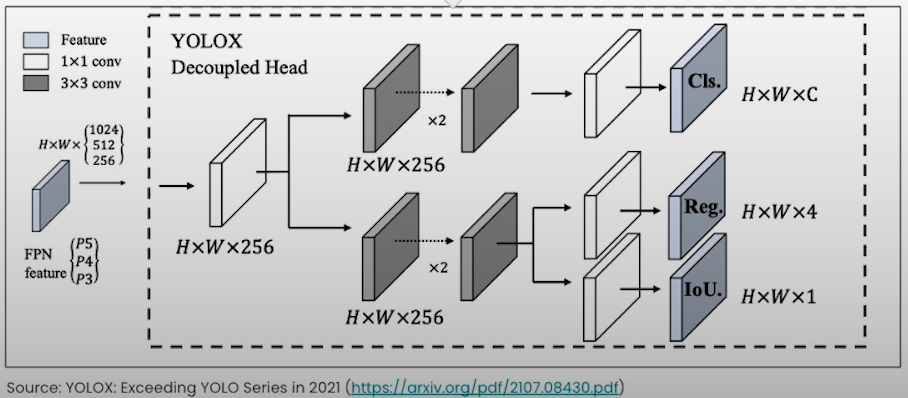（YOLO X model 是常被用作进行文档布局检测任务的模型，如果对它的结构感兴趣，可以查看原论文https://arxiv.org/pdf/2107.08430.pdf。）
    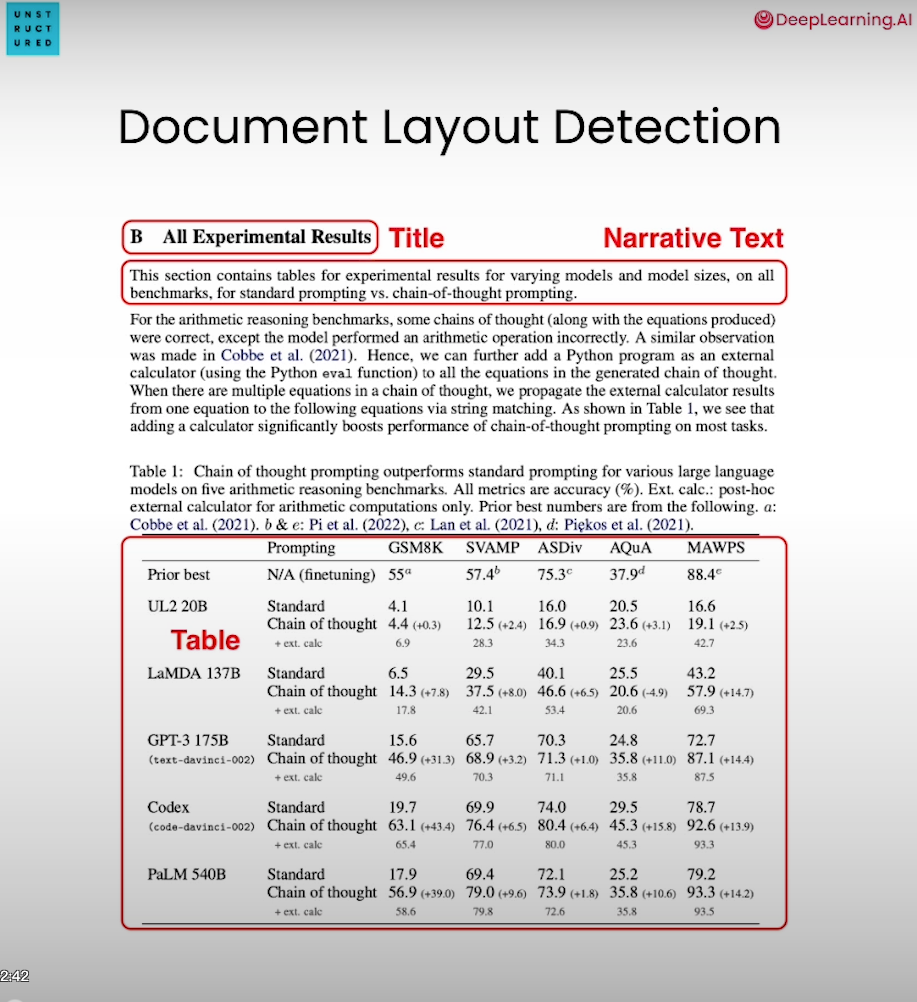（这是提取过程的示例）
- 对于第二步，只需要识别到边界框就可以直接提取内容了。

### 2.2 视觉Transformers(Vision Transformers)
视觉Transformers(ViT)完成这个任务只需要一步,并且不再需要OCR等工具。常见的结构就是DONUT(Document Understanding Transformer),可以通过编码器和解码器直接将输入的图像处理为输出的文本，并且可以训练这些模型来输出特定格式的文本，如JSON格式。
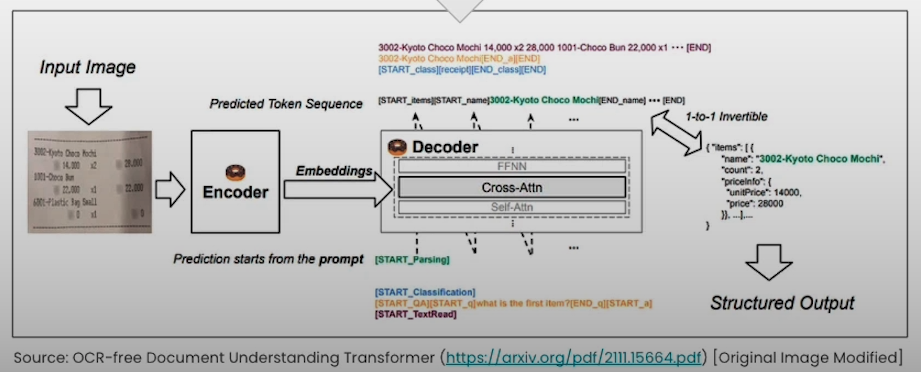（这是DONUT模型的结构示意图，如果对此感兴趣的话，可以进一步查看原论文https://arxiv.org/pdf/2111.15664.pdf)
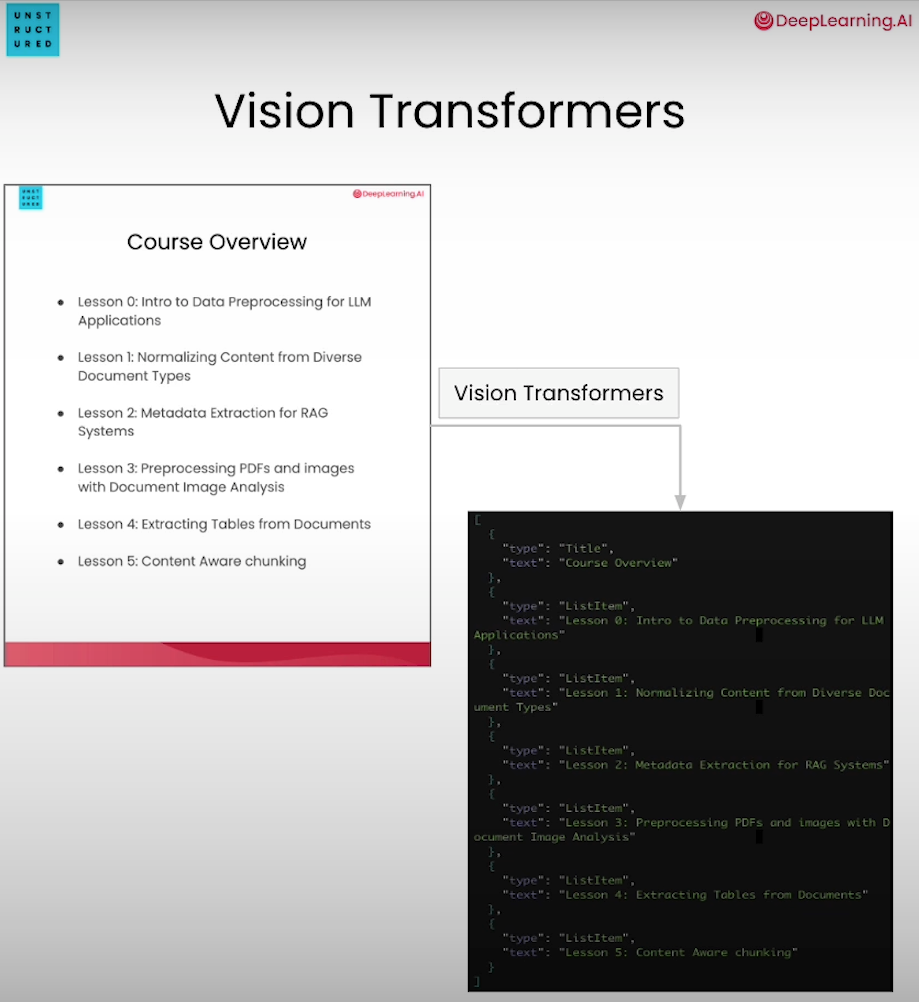(这是提取过程的示例)

### 2.3 优劣分析
- 文档布局检测的优点是可以提取到固定元素类型的合集并获得边界框的信息，方便回溯原文，但是却需要两个模块（目标检测和OCR），缺乏灵活性。
- 视觉Transformers更加灵活，可以自定义需要提取的内容，并且适用于更多类型的无结构文档。缺点在于，该方法需要使用到生成模型，容易引发幻觉或重复，并且需要较高的算力成本。



## 三、案例演示

In [1]:
# 忽略一些可能出现的警告
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 导入需要的库，如果有没有安装完成的库，可以依据根目录下的requirements.txt文件进行安装和版本控制
from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError
from unstructured.partition.html import partition_html
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import dict_to_elements

In [3]:
# Utils模块可以在根目录找到
from Utils_Ch5 import Utils

utils = Utils()

DLAI_API_KEY = utils.get_dlai_api_key()
DLAI_API_URL = utils.get_dlai_url()

# 提供注册好的API_key和Server_url
s = UnstructuredClient(api_key_auth="8DMagJnEqORgXhTvVkCWOGAdXiGS4P", server_url='https://dw-mlp7ystx.api.unstructuredapp.io')
# s = UnstructuredClient(api_key_auth="your_api_key", server_url='your_server_url')


None


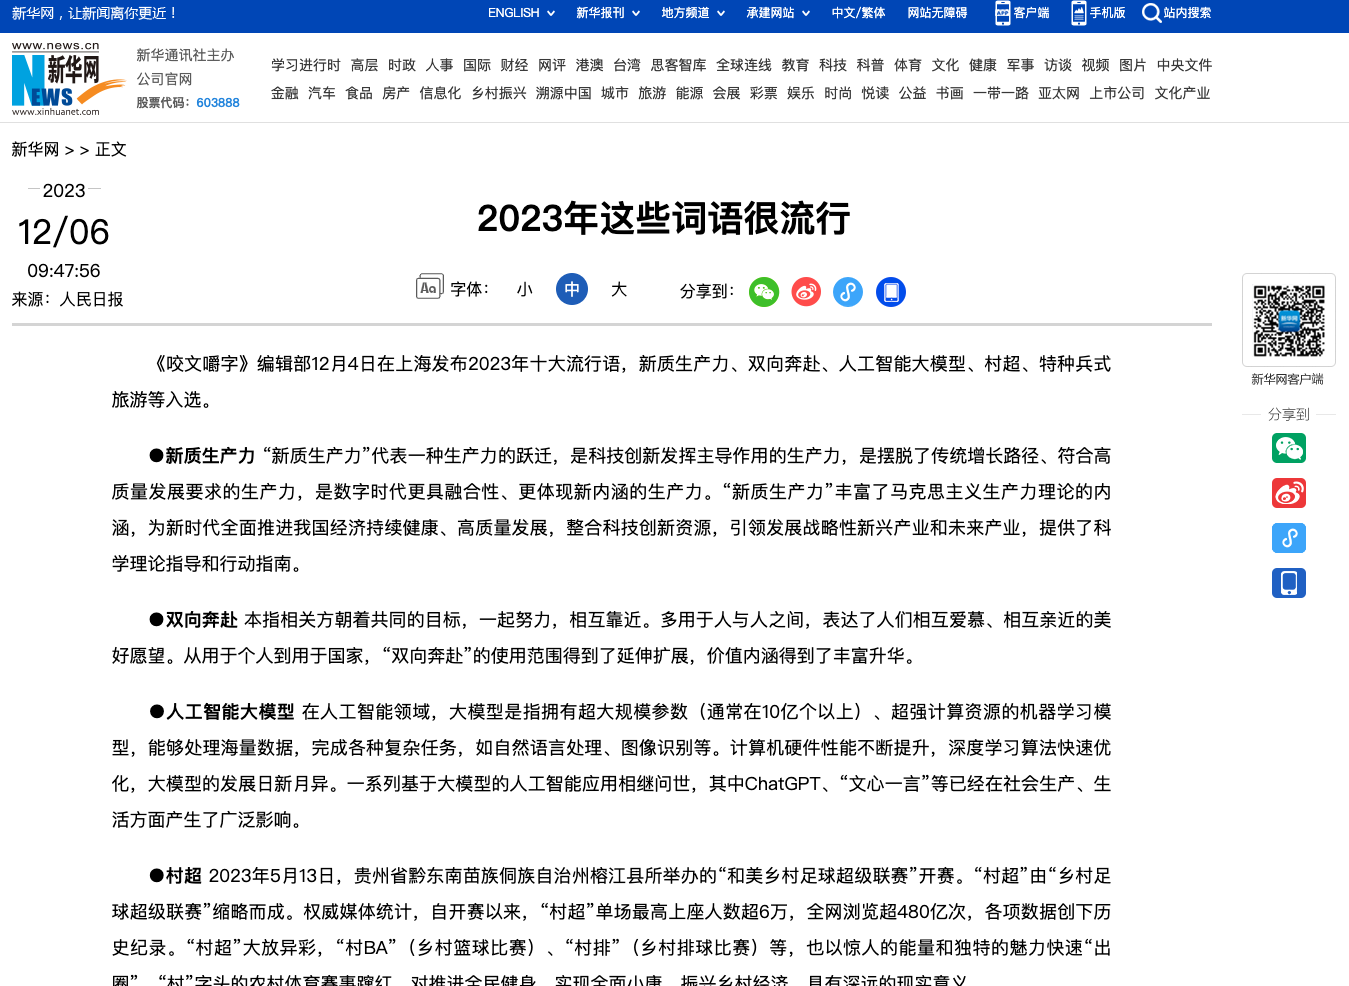

In [4]:
from IPython.display import Image
Image(filename="示例文件/2023十大流行词.png", height=600, width=600) 

我们使用不同的形式（html和pdf）表达同样的内容，来测试上述工具的效果

In [5]:
# 将内容以html的形式导入
filename = "示例文件/2023十大流行词.html"
html_elements = partition_html(filename=filename)

INFO: Reading document from string ...
INFO: Reading document ...


In [6]:
# 打印提取到的元素
for element in html_elements[:10]:
    print(f"{element.category.upper()}: {element.text}")

TITLE: 网站无障碍
TITLE: PC版本
TITLE: 首页
TITLE: 学习进行时
TITLE: 高层
TITLE: 时政
TITLE: 人事
TITLE: 国际
TITLE: 财经
TITLE: 网评


In [7]:
# 将内容以pdf的形式导入
filename = "示例文件/2023十大流行词.pdf"
pdf_elements = partition_pdf(filename=filename,strategy="fast")

INFO: PDF text extraction failed, skip text extraction...


In [8]:
# 打印提取到的元素
for element in pdf_elements[:10]:
    print(f"{element.category.upper()}: {element.text}")

In [9]:
# 使用yolox model来提取文本
with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=filename,
    )

req = shared.PartitionParameters(
    files=files,
    strategy="hi_res",
    hi_res_model_name="yolox",
)

try:
    resp = s.general.partition(req)
    dld_elements = dict_to_elements(resp.elements)
except SDKError as e:
    print(e)

INFO: Partitioning without split.
INFO: Successfully partitioned the document.


In [10]:
for element in dld_elements[:10]:
    print(f"{element.category.upper()}: {element.text}")

HEADER: 2024/6/17 16:07
IMAGE: www.news.cn e f wvaw.xinhuanet.com
UNCATEGORIZEDTEXT: 新华⽹ > > 正⽂
NARRATIVETEXT: 2023
UNCATEGORIZEDTEXT: 12/06 09:47:56
NARRATIVETEXT: 来源：⼈⺠⽇报
HEADER: 新华通讯社主办 公司官⽹ 股票代码：603888
HEADER: 2023年这些词语很流⾏- 新华⽹内蒙古频道
HEADER: 新华报刊 地⽅频道 承建⽹站 中⽂/繁体 ⽹站⽆障碍 客户端
TITLE: ENGLISH


In [11]:
# 接下来比较一下提取效果
import collections

In [12]:
len(html_elements)

253

In [13]:
html_categories = [el.category for el in html_elements]
collections.Counter(html_categories).most_common()

[('Title', 162),
 ('ListItem', 83),
 ('UncategorizedText', 7),
 ('NarrativeText', 1)]

In [14]:
len(dld_elements)

38

In [15]:
dld_categories = [el.category for el in dld_elements]
collections.Counter(dld_categories).most_common()

[('NarrativeText', 25),
 ('Header', 8),
 ('UncategorizedText', 2),
 ('Title', 2),
 ('Image', 1)]

In [16]:
import panel as pn
#import param
from Utils_Ch5 import UploadFile
pn.extension()

upld_widget = UploadFile()
pn.Row(upld_widget.widget_file_upload)

Row
    [0] FileInput(accept='.pdf,.ppt,.png,.html')

In [17]:
!ls ./示例文件

2023十大流行词.html       2023十大流行词_files      el_nino.png
2023十大流行词.pdf        el_nino.html
2023十大流行词.png        el_nino.pdf
